## Coding Practice #0505

### 1. Time series and prediction:

In [1]:
import numpy as np
import pandas as pd
import os
import warnings 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
warnings.filterwarnings('ignore')                  # Turn the warnings off.
%matplotlib inline

#### 1.1. Read in the data and explore: 

In [2]:
from google.colab import files

uploaded = files.upload()

Saving data_time_series.csv to data_time_series.csv


In [3]:
import io

df = pd.read_csv(io.StringIO(uploaded['data_time_series.csv'].decode('utf-8')), header='infer', encoding = 'latin1')
n_time_steps = df.shape[0]
print(df.shape)

(41, 1)


In [4]:
# Display the data frame.
df.head()

,Value
0,2.26483
1,3.80588
2,4.21088
3,3.48790
4,4.86365


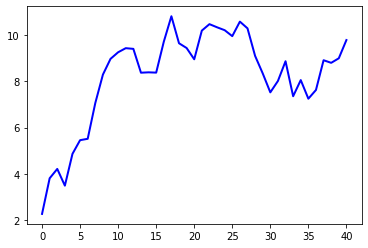

In [5]:
# Visualize the time series.
plt.plot(df.Value, c="b", linewidth=2, linestyle="-")
plt.show()

#### 1.2. Apply the exponential smoothing method and predict: 

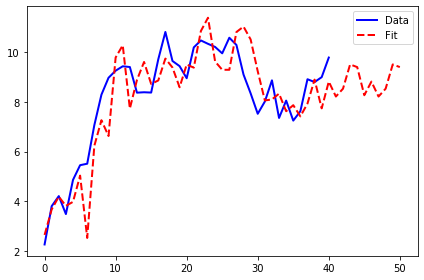

In [6]:
model = ExponentialSmoothing(df['Value'][0:40], seasonal='mul',seasonal_periods=6).fit()    # Multiplicative exponential smoothing model.
pred = model.predict(start= 0, end=50)                                                        
plt.plot(df,c='b',linewidth=2, linestyle="-", label="Data")
plt.plot(pred,c='r',linewidth=2, linestyle="--", label="Fit")
plt.legend()
plt.tight_layout()
plt.show()

### 2. Recurrent neural network (RNN):

#### 2.1. Pre-processing:

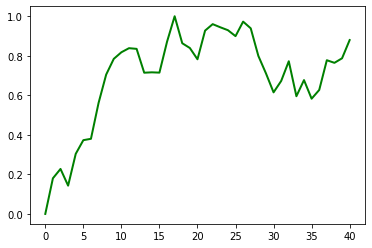

In [7]:
# Scaling.
# Please, pay attention to the vertical scale of the plot.
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(df)
plt.plot(ts_scaled,c = "g", linewidth=2, linestyle="-")
plt.show()

In [0]:
# Reshaping.
ts_scaled_2 = ts_scaled.reshape(1,-1,1)             # (batch_size, time series length, n_input)

#### 2.2. Do the necessary definitions:

Hyperparameters.

In [0]:
n_epochs = 1001                   
batch_size = 1                    # There is only 1 time series data. No other choice but 1. 
learn_rate = 0.0002       

In [0]:
n_input = 1                       # Scalar input.
n_neurons = 100                   # N# of neurons per layer.
n_output = 1                      # Scalar output.

Model.

In [11]:
# RNN or LSTM network.
# return_sequnces = True: means "Sequence to Sequence".
# input_shape = (None, n_inputs) : variable length of the time series.
my_model = Sequential()
my_model.add(SimpleRNN(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))     # RNN.
#my_model.add(LSTM(units=n_neurons,return_sequences=True, input_shape=(None, n_input)))         # LSTM.
my_model.add(TimeDistributed(Dense(units=n_output, activation="linear")))    # Wrapper.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
# View the summary.
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Define the optimizer and compile.
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "mse", optimizer = my_optimizer, metrics=["mse"])

#### 2.3. Train the model:

In [0]:
# No validation.
# CAUTION: y is X shifted by +1.
my_summary = my_model.fit(ts_scaled_2[:,:-1,:], ts_scaled_2[:,1:,:], epochs=n_epochs, batch_size = batch_size, verbose = 0)

In [15]:
my_summary.history.keys()

dict_keys(['loss', 'mean_squared_error'])

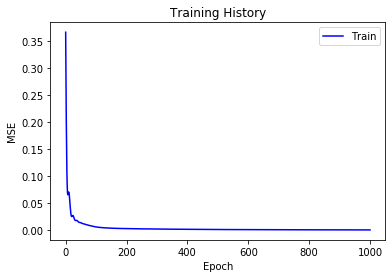

In [16]:
plt.plot(my_summary.history['mean_squared_error'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

#### 2.4. Predict the future:

In [0]:
n_ts_seed = 5                                 # Seed length.
n_predict_time_steps = 55                     # Prediction length.

In [0]:
# Prediction loop.
ts_seed = ts_scaled[0:n_ts_seed]
for i in range(n_predict_time_steps):
    X = ts_seed.reshape(1,-1,1)        # Reshape.     
    y_pred = my_model.predict(X)
    y_last= y_pred[0,-1,0]             # The last output is the predicted y.
    ts_seed = np.concatenate((ts_seed, np.array([y_last]).reshape(1,1)), axis=0)

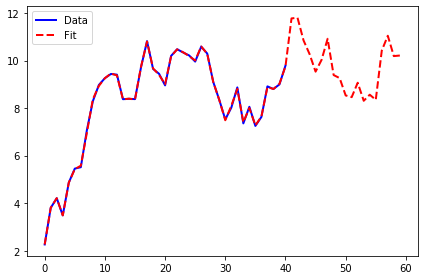

In [19]:
# Do the inverse transform and show the times series. 
ts = scaler.inverse_transform(ts_seed)
plt.plot(df.Value,c='b',linewidth=2, linestyle="-",label="Data")
plt.plot(ts,c='r',linewidth=2, linestyle="--",label="Fit")
plt.legend()
plt.tight_layout()
plt.savefig("out.png")
plt.show()